In [1]:
from data_processing import Dataset
from noise import NoiseScheduler
import matplotlib.pyplot as plt
import numpy as np
import torch.nn.functional as F
from torchvision import transforms
import torch
from torch.utils.data import TensorDataset, DataLoader
import random

seed = 22
torch.manual_seed(seed)
np.random.seed(seed)
random.seed(seed)

# Set the device to custom GPU
gpu = torch.device("cuda:0" if torch.cuda.is_available() else "cpu") # change cuda:1 to number between 0 & 5
torch.cuda.set_device(gpu)

if torch.cuda.is_available():
    print("CUDA is available!")
    print("Number of available GPUs:", torch.cuda.device_count())
    print("Current GPU:", torch.cuda.current_device())
else:
    print("CUDA is not available. Running on CPU.")

CUDA is available!
Number of available GPUs: 6
Current GPU: 0


In [2]:
if(torch.backends.cuda.is_built()) : 
    device='cuda'
elif(torch.backends.mps.is_built()) : 
    device='mps'
else : 
    device='cpu'

In [3]:
# Set to directory where data is stored
work_home = False
data_dir = "Datasets" if work_home else "/cephfs/dice/projects/L1T/diffusion/datasets/"

start_idx = 12000 # Adjust which events to look at from the dataset, make different to the training data 
end_idx = 12300
dataset = Dataset(end_idx-start_idx, (120, 72), signal_file=f"{data_dir}/CaloImages_signal.root", pile_up_file=f"{data_dir}/CaloImages_bkg.root", save=False, start_idx=start_idx, end_idx=end_idx) # 120 eta, 72 phi

In [4]:
dataset() #once this is cached, you don't have to re-load

Show original shape of image to determine which axis corresponds to eta and phi:

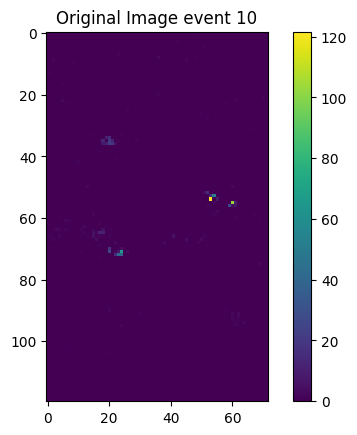

In [5]:

# Select an index for the image you want to visualize
testEvent = 10  # Change this to visualize a different image

# Access the original image from the dataset
original_image = dataset.signal[testEvent]

# Display the original image using matplotlib
plt.imshow(original_image)
plt.colorbar()
plt.title(f"Original Image event {testEvent}")
plt.show()


In [6]:
new_dim=(64,64)

saturation_value = 512 # Change saturation value here (make same as training value)
dataset.preprocess(new_dim)     # ensure these have the same values as when the model was trained

INFO:root:re-sizing
re-sizing


In [7]:
preprocess = transforms.Compose(
        [
            transforms.ToTensor()
        ]
)

MOVING DATA TO GPU

In [8]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [9]:
# Extract horizontal strip from y=26 to y=38 (12 pixels tall)
# Change how much of image to train model on here
strip_size = 'full_image'

# Change size of strip here
strip_top = 26
strip_bottom = 38

MSE_y_start = strip_top
MSE_y_end = strip_bottom

if strip_size == 'strip':
    y_start = strip_top
    y_end = strip_bottom
    
elif strip_size == 'full_image':
    y_start = 0
    y_end = 64




In [10]:
clean_frames = preprocess(dataset.signal).float().permute(1, 2, 0).unsqueeze(1)[:, :, y_start:y_end, :]#pytorch symantics
pile_up = preprocess(dataset.pile_up).float().permute(1, 2, 0).unsqueeze(1)[:, :, y_start:y_end, :]

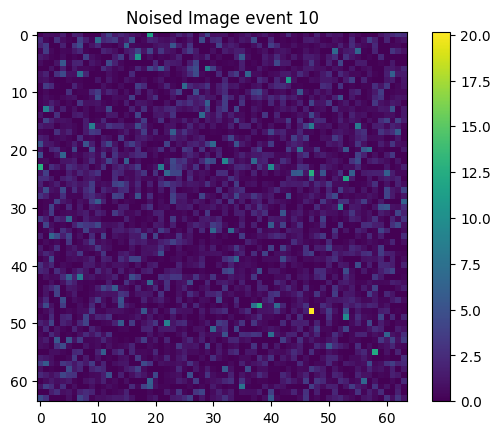

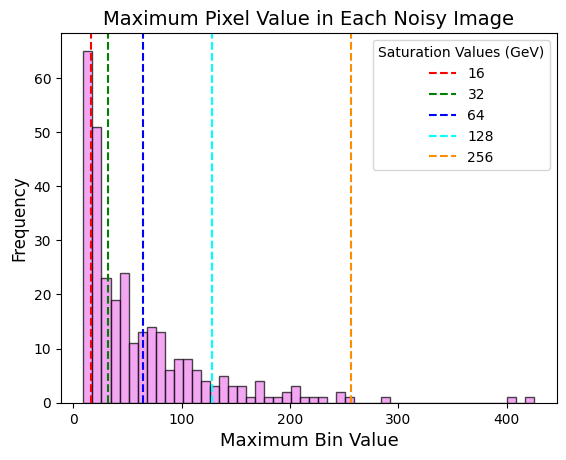

Threshold (GeV)      Perc of Events Above Threshold(%)
16                   82.00                    
32                   56.00                    
64                   33.33                    
128                  11.67                    
256                  1.33                     
512                  0.00                     


In [11]:
# Create noise scheduler
noise_scheduler = NoiseScheduler('pile-up')

# Each unit of timestep represents an additional 5 pile-up events (max 40 = 200PU)
timestep = torch.LongTensor([40]).to(device)

# Initialize the array to hold the maximum pixel values
noisy_max_bin = np.zeros(end_idx - start_idx)

# Define DataLoader for inference batches
batch_size = 100
inference_dataset = TensorDataset(clean_frames)
inference_dataloader = DataLoader(inference_dataset, batch_size=batch_size, shuffle=False)

# Loop through the DataLoader
for batch_idx, (clean_batch,) in enumerate(inference_dataloader):
    clean_batch = clean_batch.to(device)
    random_seed = np.random.randint(0, end_idx - start_idx)

    # Generate the noisy image at maxTimestep (200 pile-ups)
    noisy_images, noise = noise_scheduler.add_noise(
        clean_frame=clean_batch, 
        noise_sample=pile_up, 
        timestep=timestep, 
        random_seed=random_seed, 
        n_events=end_idx - start_idx
    )

    noisy_images = noisy_images.to(device)

    # Update the maximum pixel values
    batch_start = batch_idx * batch_size
    batch_end = batch_start + clean_batch.size(0)
    
    # Calculate the maximum pixel value for each image in the batch
    noisy_max_bin[batch_start:batch_end] = noisy_images.view(noisy_images.size(0), -1).max(dim=1)[0].cpu().numpy()

    # Visualize one image from the batch (e.g., the first image in the batch)
    if batch_idx == 0:  # Adjust condition to visualize other batches if needed
        plt.imshow(noisy_images[testEvent].cpu().squeeze())
        plt.colorbar()
        plt.title(f"Noised Image event {testEvent}")
        plt.show()

# Plot histogram to see distribution of maximum pixel value in each event
plt.hist(noisy_max_bin, bins=50, color='violet', alpha=0.7, edgecolor='black')
plt.title('Maximum Pixel Value in Each Noisy Image', fontsize=14)
plt.xlabel('Maximum Bin Value', fontsize=13)
plt.ylabel('Frequency', fontsize=12)
# Plot vertical lines at x values of 16, 32, 64
plt.axvline(x=16, color='r', linestyle='--', label='16')
plt.axvline(x=32, color='green', linestyle='--', label='32')
plt.axvline(x=64, color='blue', linestyle='--', label='64')
plt.axvline(x=128, color='cyan', linestyle='--', label='128')
plt.axvline(x=256, color='darkorange', linestyle='--', label='256')

# Add legend
plt.legend(title='Saturation Values (GeV)')
plt.show()

# Calculate the percentage of events with maximum pixel value greater than given thresholds
thresholds = [16, 32, 64, 128, 256, 512]
percentages = [(noisy_max_bin > threshold).sum() / len(noisy_max_bin) * 100 for threshold in thresholds]

# Print the table
print(f"{'Threshold (GeV)':<20} {'Perc of Events Above Threshold(%)':<25}")
for threshold, percentage in zip(thresholds, percentages):
    print(f"{threshold:<20} {percentage:<25.2f}")

In [12]:
noisy_image, noise = noise_scheduler.add_noise(clean_frame=clean_frames[testEvent].unsqueeze(0), noise_sample=pile_up, timestep=timestep, random_seed=random_seed, n_events = end_idx-start_idx)

# Apply saturation value clipping
noisy_image = torch.clamp(noisy_image, max=saturation_value)

Text(0.5, 1.0, 'Noised Image event 10')

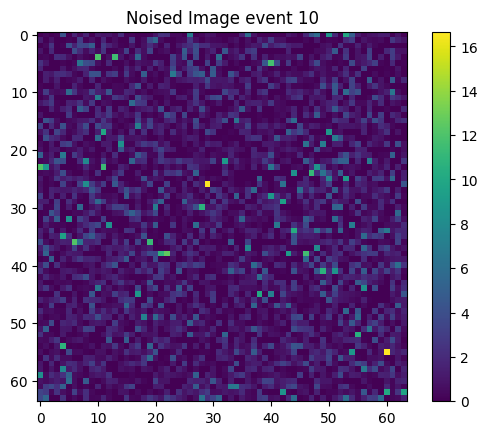

In [13]:
plt.imshow(noisy_image[0][0].cpu())
plt.colorbar()
plt.title(f"Noised Image event {testEvent}")

In [14]:
from models_stripped_kernels import Model, UNetLite_hls # Make sure to import same model as training

modtype = 'UNet_lite' # Change Model type here

if modtype == 'UNet2d':
    model = Model('UNet', new_dim)
    model = model.__getitem__()

elif modtype == 'UNet_lite':
    model = UNetLite_hls()

# Move model to GPU
model = model.to(device)    

print(model)

/software/sa21722/miniconda3/envs/sd_env/lib/python3.9/site-packages/diffusers/models/transformers/transformer_2d.py:34: FutureWarning: `Transformer2DModelOutput` is deprecated and will be removed in version 1.0.0. Importing `Transformer2DModelOutput` from `diffusers.models.transformer_2d` is deprecated and this will be removed in a future version. Please use `from diffusers.models.modeling_outputs import Transformer2DModelOutput`, instead.
  deprecate("Transformer2DModelOutput", "1.0.0", deprecation_message)


UNetLite_hls(
  (relu): ReLU()
  (emb1): Linear(in_features=4, out_features=1, bias=True)
  (convd1_1): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), bias=False)
  (normd1_1): GroupNorm(8, 16, eps=1e-05, affine=True)
  (convd1_2): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), bias=False)
  (normd1_2): GroupNorm(8, 16, eps=1e-05, affine=True)
  (pool1): Conv2d(16, 16, kernel_size=(3, 3), stride=(2, 2), bias=False)
  (normd2_1): GroupNorm(8, 16, eps=1e-05, affine=True)
  (emb2): Linear(in_features=4, out_features=16, bias=True)
  (convd2_1): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), bias=False)
  (normd2_2): GroupNorm(8, 16, eps=1e-05, affine=True)
  (convd2_2): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), bias=False)
  (normd2_3): GroupNorm(8, 16, eps=1e-05, affine=True)
  (pool2): Conv2d(16, 16, kernel_size=(3, 3), stride=(2, 2), bias=False)
  (normb1_1): GroupNorm(8, 16, eps=1e-05, affine=True)
  (emb4): Linear(in_features=4, out_features=16, bias=True)
  (convb1_1

In [15]:
if modtype == 'UNet2d':
    # Use 1st line for huggingface trained model
    # Use 2nd line for retrained model

    #trained_model_path = '/cephfs/dice/projects/L1T/diffusion/trained_models/trained_diffusor.pt'
    trained_model_path = 'retrained_models_UNet2d/saturation=512/model_epoch_9.pt'

elif modtype == 'UNet_lite': 
    trained_model_path = 'trained_models_lite/const_kernels_16/model_epoch_9.pt' # Specify folder for which trained model here!

print(trained_model_path)

trained_models_lite/const_kernels_16/model_epoch_9.pt


In [16]:
checkpoint = torch.load(trained_model_path, map_location=device)  # Ensure checkpoint is loaded to the correct device
model.load_state_dict(checkpoint)

<All keys matched successfully>

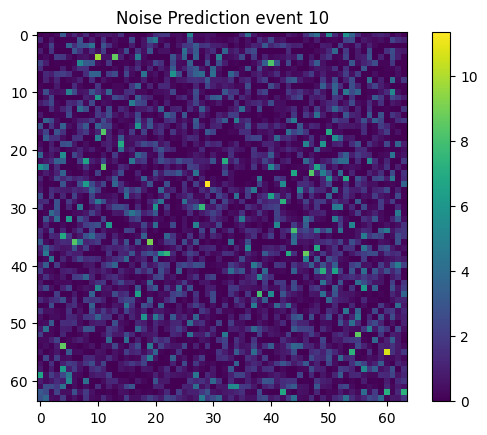

In [17]:
noisy_image = noisy_image.to(device)
if modtype == 'UNet2d':
    noise_pred = model(noisy_image, timestep, return_dict=False)[0]
elif modtype == 'UNet_lite':
    noise_pred = model(noisy_image, timestep)

# Display the noise prediction
ims = plt.imshow(noise_pred.detach().squeeze().squeeze().cpu()) # Move prediction back to CPU for visualization
plt.colorbar(ims)
plt.title(f"Noise Prediction event {testEvent}")
plt.show()

In [18]:
de_noised = F.relu(noisy_image - noise_pred)

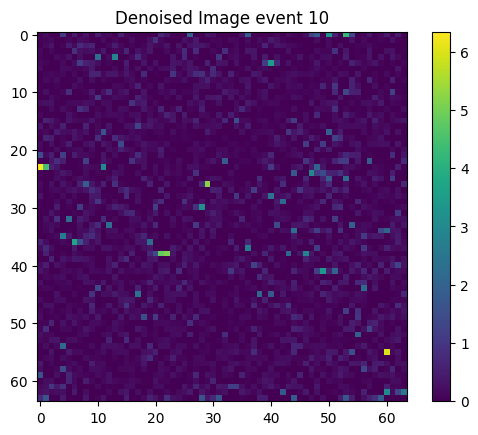

In [19]:
im = plt.imshow(de_noised.detach().cpu().squeeze().squeeze())
plt.colorbar(im)
plt.title(f"Denoised Image event {testEvent}")
plt.show()

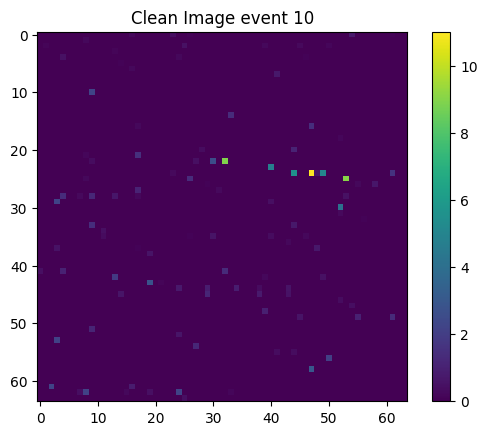

In [20]:
im2 = plt.imshow(clean_frames[testEvent].squeeze().cpu())
plt.colorbar(im2)
plt.title(f"Clean Image event {testEvent}")
plt.show()

In [21]:
err = (clean_frames[testEvent].cpu().squeeze()) - de_noised.detach().cpu()
print(f"MSE for event {testEvent}: {np.mean((err.numpy())**2)}")


MSE for event 10: 0.24460595846176147


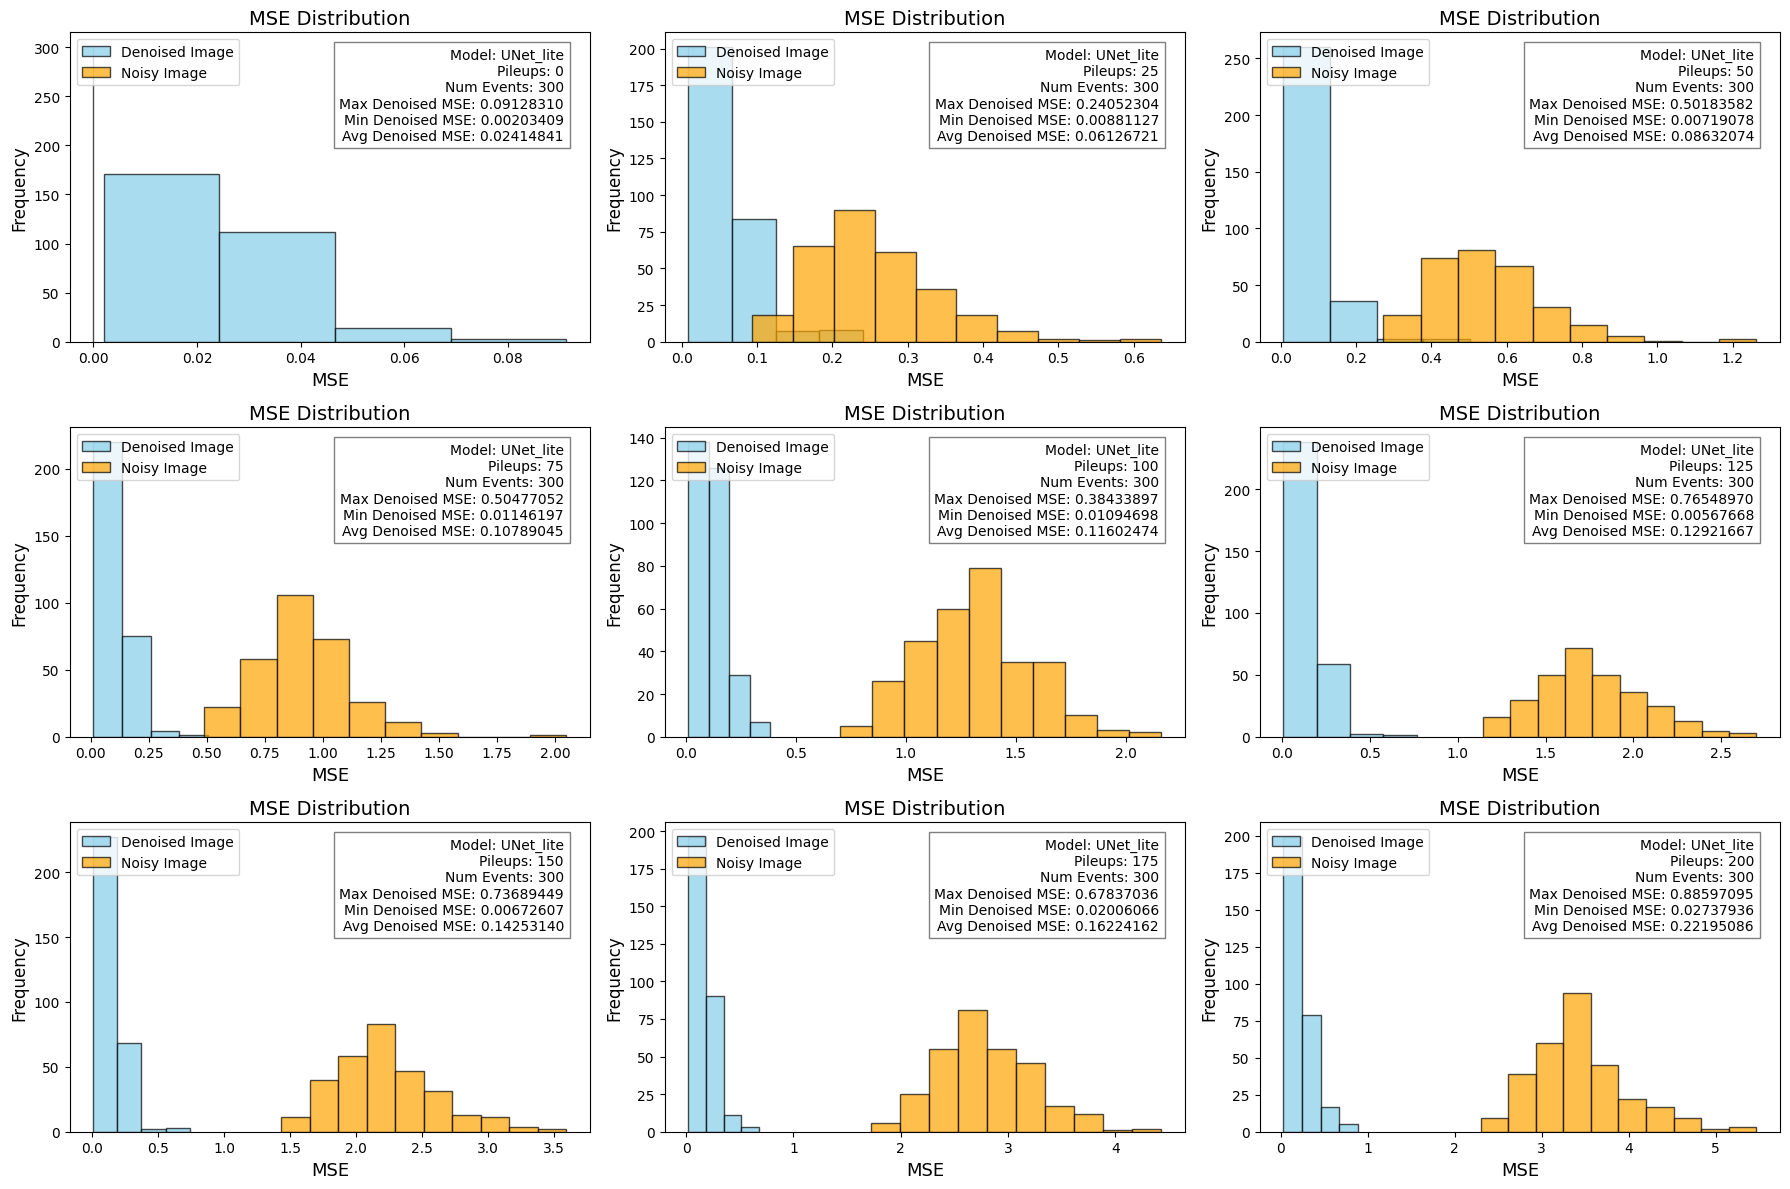

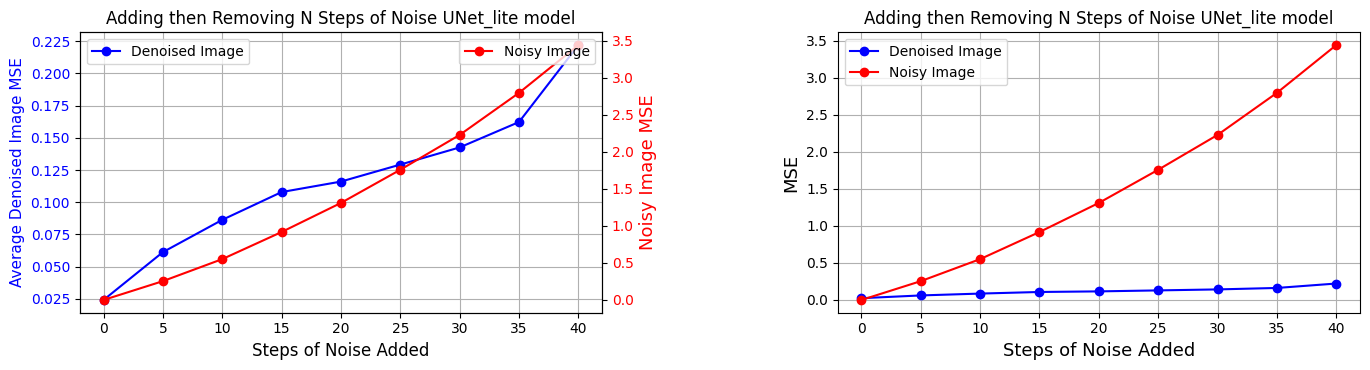

In [22]:
timesteps = [0, 5, 10, 15, 20, 25, 30, 35, 40] # Which timesteps to perform denoising at
num_events = end_idx-start_idx # Number of trials where denoising process is performed and evaluated
batch_size = 100 # Adjust as needed
num_batches = num_events // batch_size

# Create arrays to hold MSEs for each event at each timestep
denoised_results = np.zeros((len(timesteps), num_batches, batch_size))  # For MSEs between denoised image and clean image
noisy_results = np.zeros((len(timesteps), num_batches, batch_size))  # For MSEs between noisy image and clean image

if len(timesteps) % 3 != 0: # Add extra row if number not divisible by 3 to hold the remaining plots
    extra_row = 1
else:
    extra_row = 0

fig, axes = plt.subplots(len(timesteps) // 3 + extra_row, 3, figsize=(18, 12))  # eg. 3x3 grid for 9 timesteps

# Define DataLoader for inference batches
inference_dataset = TensorDataset(clean_frames)
inference_dataloader = DataLoader(inference_dataset, batch_size=batch_size, shuffle=False)

# Add a specific amount of noise at each timestep
for idx, timestep_value in enumerate(timesteps): # pairs up values of timesteps (=timestep_value) with their indexes(=idx)

    # Run the denoising process a number of  times
    for batch_idx, (clean_batch,) in enumerate(inference_dataloader):
        clean_batch = clean_batch.to(device)
        noise_scheduler = NoiseScheduler('pile-up')
        timestep = torch.LongTensor([timestep_value]).to(device)
        random_seed = np.random.randint(0, end_idx - start_idx)

        # Create noisy image and noise prediction
        noisy_images, noise = noise_scheduler.add_noise(
            clean_frame=clean_batch, 
            noise_sample=pile_up, 
            timestep=timestep, 
            random_seed=random_seed, 
            n_events=end_idx - start_idx
        )

        # Apply saturation value clipping and scaling
        noisy_images = torch.clamp(noisy_images, max=saturation_value)
        
        if modtype == 'UNet2d':
            noise_pred = model(noisy_images, timestep, return_dict=False)[0]
        elif modtype == 'UNet_lite':
            noise_pred = model(noisy_images, timestep)

        de_noised = F.relu(noisy_images - noise_pred)
        
        # Calculate the difference between denoised image and clean image
        denoised_err = (clean_batch) - de_noised
        denoised_MSE = torch.mean((denoised_err.cpu())**2, dim=[1, 2, 3])
        denoised_results[idx, batch_idx] = denoised_MSE.detach().numpy()

        # Calculate the difference between noisy image and clean image
        noisy_err = (clean_batch) - noisy_images
        noisy_MSE = torch.mean((noisy_err.cpu())**2, dim=[1, 2, 3])
        noisy_results[idx, batch_idx] = noisy_MSE.numpy()
   
    # Calculate and plot average MSE vs. timestep
    av_denoised_MSE = denoised_results.mean(axis=-1).mean(axis=-1)
    av_noisy_MSE = noisy_results.mean(axis=-1).mean(axis=-1)
    
    # Plot required number of histograms
    ax = axes[idx // 3, idx % 3]  # Determine subplot position

    # Plot histogram for denoised results at each timestep
    denoised_mses_bins = np.linspace(np.min(denoised_results[idx]), np.max(denoised_results[idx]), 5)
    ax.hist(denoised_results[idx].flatten(), bins=denoised_mses_bins, color='skyblue', alpha=0.7, edgecolor='black', label='Denoised Image')

    # Plot histogram for noisy results at each timestep on same plot
    noisy_mses_bins = np.linspace(np.min(noisy_results[idx]), np.max(noisy_results[idx]), 11)
    ax.hist(noisy_results[idx].flatten(), bins=noisy_mses_bins, color='orange', alpha=0.7, edgecolor='black', label='Noisy Image')
    ax.set_title('MSE Distribution', fontsize=14)
    ax.set_xlabel('MSE', fontsize=13)
    ax.set_ylabel('Frequency', fontsize=12)
    ax.legend(loc='upper left')
    
    # Adding text box with statistics
    textstr = '\n'.join((
        f'Model: {modtype}',
        f'Pileups: {timestep_value*5}',
        f'Num Events: {num_events}',
        f'Max Denoised MSE: {np.max(denoised_results[idx]):.8f}',
        f'Min Denoised MSE: {np.min(denoised_results[idx]):.8f}',
        f'Avg Denoised MSE: {av_denoised_MSE[idx]:.8f}'
    ))
    ax.text(0.95, 0.95, textstr, transform=ax.transAxes, fontsize=10,
            verticalalignment='top', horizontalalignment='right',
            bbox=dict(facecolor='white', alpha=0.5))

fig.tight_layout()
plt.show()

# Calculate and plot average MSE vs. level of noise added
fig, axs = plt.subplots(1, 2, figsize=(16, 6))

# Plot both on same graph with different axes
axs[0].plot(timesteps, av_denoised_MSE, marker='o', linestyle='-', color='blue', label='Denoised Image')
axs[0].set_title(f'Adding then Removing N Steps of Noise {modtype} model', fontsize=12)
axs[0].set_xlabel('Steps of Noise Added', fontsize=12)
axs[0].set_ylabel('Average Denoised Image MSE', color='blue', fontsize=11)
axs[0].tick_params(axis='y', labelcolor='blue')
axs[0].grid(True)
axs[0].legend(loc='upper left')

axs[0] = axs[0].twinx()
axs[0].plot(timesteps, av_noisy_MSE, marker='o', linestyle='-', color='red', label='Noisy Image')
axs[0].set_ylabel('Noisy Image MSE', color='red', fontsize=13)
axs[0].tick_params(axis='y', labelcolor='red')
axs[0].legend(loc='upper right')

# Plot both on same graph with same axis
axs[1].plot(timesteps, av_denoised_MSE, marker='o', linestyle='-', color='blue', label='Denoised Image')
axs[1].plot(timesteps, av_noisy_MSE, marker='o', linestyle='-', color='red', label='Noisy Image')
axs[1].set_title(f'Adding then Removing N Steps of Noise {modtype} model', fontsize=12)
axs[1].set_xlabel('Steps of Noise Added', fontsize=13)
axs[1].set_ylabel('MSE', fontsize=13)
axs[1].legend()
axs[1].grid(True)

fig.tight_layout(pad=9)  # Adjust subplots to fit into figure area.

plt.show()

The avg MSE for the strip (y=26 -> y=38) across 300 events is: 0.17737916710476084
The avg MSE for the full_image across 300 events is: 0.20467646525551877
0.0000 % of events reached the saturation energy of 512 GeV


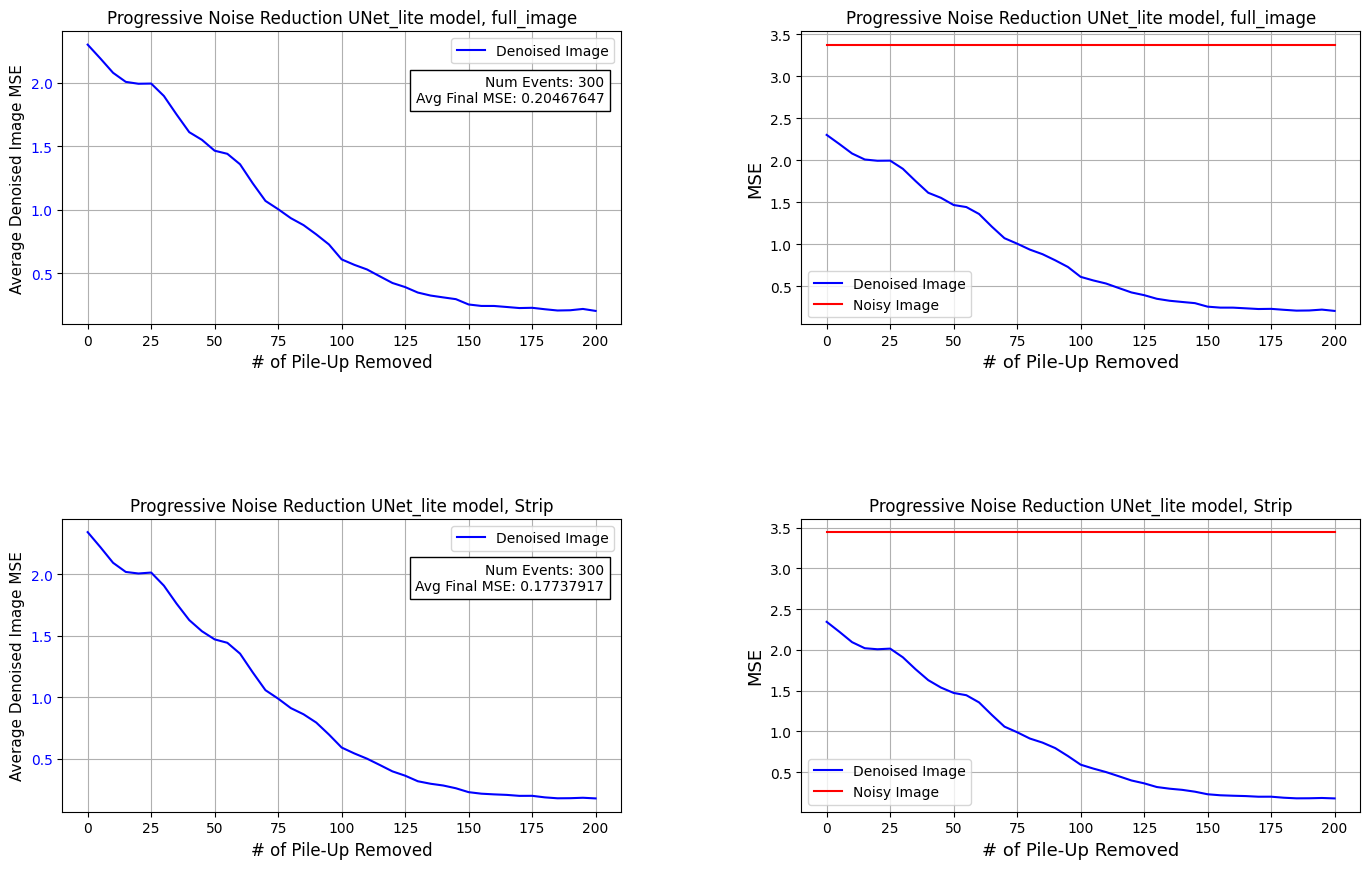

In [23]:
timesteps = np.arange(0, 41, 1)  # Which timesteps to perform denoising at

num_events = end_idx - start_idx  # Number of trials
batch_size = 100  # Define batch size
num_batches = num_events // batch_size

noise_scheduler = NoiseScheduler('pile-up')
maxTimestep = torch.LongTensor([40]).to(device)

# Create arrays to hold MSEs for each event at each timestep
denoised_results = np.zeros((len(timesteps), num_batches, batch_size))  # For MSEs between denoised image and clean image
denoised_results_strip = np.zeros((len(timesteps), num_batches, batch_size))
noisy_results = np.zeros((num_batches, batch_size))  # For MSEs between noisy image and clean image
noisy_results_strip = np.zeros((num_batches, batch_size))

inference_dataset = TensorDataset(clean_frames)
inference_dataloader = DataLoader(inference_dataset, batch_size=batch_size, shuffle=False)

for idx, timestep_value in enumerate(timesteps):
    timestep = torch.LongTensor([timestep_value]).to(device)

    for batch_idx, (clean_batch,) in enumerate(inference_dataloader):
        clean_batch = clean_batch.to(device)
        random_seed = np.random.randint(0, end_idx - start_idx)
        # Generate the noisy image at maxTimestep (200 pile-ups)
        noisy_images, noise = noise_scheduler.add_noise(
            clean_frame=clean_batch, 
            noise_sample=pile_up, 
            timestep=maxTimestep, 
            random_seed=random_seed, 
            n_events=end_idx - start_idx
        )

        # Apply saturation value clipping and scaling
        noisy_images = torch.clamp(noisy_images, max=saturation_value)

        if modtype == 'UNet2d':
            noise_pred = model(noisy_images, timestep, return_dict=False)[0]
        elif modtype == 'UNet_lite':
            noise_pred = model(noisy_images, timestep)

        de_noised = F.relu(noisy_images - noise_pred)
        
        # Calculate the difference between denoised image and clean image
        denoised_err = (clean_batch.squeeze()) - de_noised.squeeze()
        denoised_MSE = torch.mean((denoised_err.cpu()) ** 2, dim=(1, 2))
        denoised_results[idx, batch_idx] = denoised_MSE.detach().numpy()
        denoised_MSE_strip = torch.mean((denoised_err[:,MSE_y_start:MSE_y_end,:].cpu()) ** 2, dim=(1, 2))
        denoised_results_strip[idx, batch_idx] = denoised_MSE_strip.detach().numpy()

        # Calculate the difference between noisy image and clean image
        noisy_err = (clean_batch.squeeze() - noisy_images.squeeze())
        noisy_MSE = torch.mean((noisy_err.cpu()) ** 2, dim=(1, 2))
        noisy_results[batch_idx] = noisy_MSE.numpy()
        noisy_MSE_strip = torch.mean((noisy_err[:,MSE_y_start:MSE_y_end,:].cpu()) ** 2, dim=(1, 2))
        noisy_results_strip[batch_idx] = noisy_MSE_strip.numpy()


        if timestep_value == 50 and batch_idx == 0:  # Look at how much pileup removal in the timestep value
            fig, axs = plt.subplots(1, 4, figsize=(32, 6))

            im0 = axs[0].imshow(noise_pred[testEvent].detach().cpu().squeeze())  # Move prediction back to CPU for visualization
            axs[0].set_title(f"Noise Prediction for event {batch_idx * batch_size}")
            fig.colorbar(im0, ax=axs[0])

            im1 = axs[1].imshow(noisy_images[testEvent].detach().cpu().squeeze())
            axs[1].set_title(f"Noisy Image for Event {batch_idx * batch_size}")
            fig.colorbar(im1, ax=axs[1])

            im2 = axs[2].imshow(de_noised[testEvent].detach().cpu().squeeze())
            axs[2].set_title(f"Denoised Image for Event {batch_idx * batch_size}")
            fig.colorbar(im2, ax=axs[2])

            im3 = axs[3].imshow(clean_batch[testEvent].cpu().squeeze())
            axs[3].set_title(f"Clean Image for Event {batch_idx * batch_size}")
            fig.colorbar(im3, ax=axs[3])
            plt.show()

            # Print the maximum pixel value across the entire noisy image
            max_pixel_value = noisy_images.max().item()
            print(f"The maximum pixel value in the noisy image for Event {batch_idx * batch_size} is: {max_pixel_value}")

# Calculate and plot average MSE vs. timestep
av_denoised_MSE = denoised_results.mean(axis=-1).mean(axis=-1)
av_noisy_MSE = noisy_results.mean(axis=-1).mean(axis=-1)

av_denoised_MSE_strip = denoised_results_strip.mean(axis=-1).mean(axis=-1)
av_noisy_MSE_strip = noisy_results_strip.mean(axis=-1).mean(axis=-1)

if strip_size == 'full_image':
    fig, axs = plt.subplots(2, 2, figsize=(16, 11))
    plot_pos1 = 0, 0
    plot_pos2 = 0, 1

elif strip_size == 'strip':
    fig, axs = plt.subplots(1, 2, figsize=(16, 6))
    plot_pos1 = 0
    plot_pos2 = 1

# Adding text box with statistics
textbox = '\n'.join((
    f'Num Events: {num_events}',
    f'Avg Final MSE: {av_denoised_MSE[-1]:.8f}'
))

textbox2 = '\n'.join((
    f'Num Events: {num_events}',
    f'Avg Final MSE: {av_denoised_MSE_strip[-1]:.8f}'
))

axs[plot_pos1].plot(timesteps * 5, av_denoised_MSE, linestyle='-', color='blue', label='Denoised Image')
axs[plot_pos1].set_title(f'Progressive Noise Reduction {modtype} model, {strip_size}', fontsize=12)
axs[plot_pos1].set_xlabel('# of Pile-Up Removed', fontsize=12)
axs[plot_pos1].set_ylabel('Average Denoised Image MSE', fontsize=11)
axs[plot_pos1].tick_params(axis='y', labelcolor='blue')
axs[plot_pos1].grid(True)
axs[plot_pos1].legend(loc='upper right')
axs[plot_pos1].text(0.97, 0.85, textbox, transform=axs[plot_pos1].transAxes, fontsize=10,
                    verticalalignment='top', horizontalalignment='right',
                    bbox=dict(facecolor='white', alpha=1))

axs[plot_pos2].plot(timesteps * 5, av_denoised_MSE, linestyle='-', color='blue', label='Denoised Image')
axs[plot_pos2].plot(timesteps * 5, [av_noisy_MSE] * len(timesteps), linestyle='-', color='red', label='Noisy Image')
axs[plot_pos2].set_title(f'Progressive Noise Reduction {modtype} model, {strip_size}', fontsize=12)
axs[plot_pos2].set_xlabel('# of Pile-Up Removed', fontsize=13)
axs[plot_pos2].set_ylabel('MSE', fontsize=13)
axs[plot_pos2].legend()
axs[plot_pos2].grid(True)

if strip_size == 'full_image':
    axs[1, 0].plot(timesteps * 5, av_denoised_MSE_strip, linestyle='-', color='blue', label='Denoised Image')
    axs[1, 0].set_title(f'Progressive Noise Reduction {modtype} model, Strip', fontsize=12)
    axs[1, 0].set_xlabel('# of Pile-Up Removed', fontsize=12)
    axs[1, 0].set_ylabel('Average Denoised Image MSE', fontsize=11)
    axs[1, 0].tick_params(axis='y', labelcolor='blue')
    axs[1, 0].grid(True)
    axs[1, 0].legend(loc='upper right')
    axs[1, 0].text(0.97, 0.85, textbox2, transform=axs[1,0].transAxes, fontsize=10,
                    verticalalignment='top', horizontalalignment='right',
                    bbox=dict(facecolor='white', alpha=1))

    axs[1, 1].plot(timesteps * 5, av_denoised_MSE_strip, linestyle='-', color='blue', label='Denoised Image')
    axs[1, 1].plot(timesteps * 5, [av_noisy_MSE_strip] * len(timesteps), linestyle='-', color='red', label='Noisy Image')
    axs[1, 1].set_title(f'Progressive Noise Reduction {modtype} model, Strip', fontsize=12)
    axs[1, 1].set_xlabel('# of Pile-Up Removed', fontsize=13)
    axs[1, 1].set_ylabel('MSE', fontsize=13)
    axs[1, 1].legend()
    axs[1, 1].grid(True)
    print(f'The avg MSE for the strip (y={MSE_y_start} -> y={MSE_y_end}) across {num_events} events is:', av_denoised_MSE_strip[-1])

print(f'The avg MSE for the {strip_size} across {num_events} events is:', av_denoised_MSE[-1])
print(f'{(np.sum(noisy_max_bin == saturation_value) / noisy_max_bin.size) * 100:.4f} % of events reached the saturation energy of {saturation_value} GeV')
fig.tight_layout(pad=9)  # Adjust subplots to fit into figure area.
plt.show()